# ABIDE Subtype analysis
The goal of this notebook is to run a subtype analysis on the ABIDE dataset and to look at the subtype weights following Pierre Orban's analysis. Here are the central research questions:

1. What are subtypes of scores maps for different networks (7 network resolution on Cambridge) and how do they look like?
2. What are the individual subject weights for these subtypes (violin plots and Pierre's matrix)
3. For which networks and subtypes is diagnosis a significant predictor of weights?
4. What do weights for these subtypes and networks look like for patients and healthy controls?
5. For which networks and subtypes are dimensional scores like IQ significant predictors of weights?
5. What does the scatterplot of weights over IQ look like?

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import nilearn as nil
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.sandbox.stats import multicomp as smi

In [2]:
%matplotlib inline

# Paths

In [3]:
# Paths
scale = 20
name = 'n308_sample'
mtp = 'stability_maps'
prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_2box_308_sample.csv'
netstack_path = '/data1/subtypes/serial_preps/netstack_demeaned_{}_scale_{:03d}.npy'.format(name, scale)
netraw_path = '/data1/subtypes/serial_preps/netstack_raw_{}_scale_{:03d}.npy'.format(name, scale)
corrmat_path = '/data1/subtypes/serial_preps/correlation_matrix_{}_scale_{:03d}.npy'.format(name, scale)
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
out_path = '/data1/subtypes/sc12'

In [4]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [5]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)

In [6]:
# add coded variable for ratio of VIQ and PIQ
pheno['VerbRatio'] = pheno['VIQ'] / pheno['PIQ']

In [7]:
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()

In [8]:
# Turn the priors into an image
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp = np.zeros((prior_data.shape + (scale,)))
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp[..., sc_id] = tmp
prior_img = nib.Nifti1Image(prior_temp, affine=m_img.get_affine(), header=m_img.get_header())

# Define some functions and the niak colormap

In [9]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

In [10]:
def show_subtype(net_id, sbt_id, gdavg_img, sbt_store,
                 sbt_store_demeaned, view_mode='x', threshold=0.1, 
                 view_range=[-70,-50, -30, -10, 10, 30, 50, 70]):
    # Show the subtype
    fig = plt.figure(figsize=(24,50))
    gs = gridspec.GridSpec(12, 2, hspace=0.3)

    ax1 = fig.add_subplot(gs[0,0])
    nlp.plot_glass_brain(nil.image.index_img(gdavg_img, net_id), cmap=plt.cm.gnuplot, 
                             axes=ax1, colorbar=False, title='Scores average network {}'.format(net_id+1),
                            vmin=0, vmax=1)

    ax2 = fig.add_subplot(gs[0,1])
    # Turn the vectorized subtype into a volume
    sbt = sbt_store[net_id,sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    nlp.plot_glass_brain(sbt_img, cmap=plt.cm.gnuplot, 
                         axes=ax2, colorbar=True, title='Subtype {} network {}'.format(sbt_id+1, net_id+1),
                        vmin=0, vmax=1)
    
    ax3 = fig.add_subplot(gs[1,:])
    # Turn the vectorized demeaned subtype into a volume
    sbt_dm = sbt_store_demeaned[net_id,sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt_dm
    sbt_dm_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    nlp.plot_stat_map(sbt_dm_img, axes=ax3, display_mode=view_mode, threshold=threshold, 
                      cut_coords=view_range, black_bg=True)
    
    return fig

In [11]:
def report_weights(net_id, sbt_id, sub_asd, sub_tdc, weight_store):
    # Look at the weights for subtype 5
    sbt_weights = weight_store[net_id, sbt_id,:]
    # Get the weights for the asd and tdc cases
    asd_weights = sbt_weights[sub_asd]
    tdc_weights = sbt_weights[sub_tdc]
    n_asd = np.sum(sub_asd)
    n_tdc = np.sum(sub_tdc)
    # T-test
    [t,p] = st.ttest_ind(asd_weights, tdc_weights)

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    # Indices
    ind_asd = np.ones(n_asd) + (np.random.random(n_asd)*2-1)*0.05
    ind_tdc = np.ones(n_tdc) + (np.random.random(n_tdc)*2-1)*0.05 + 1

    ax1.plot(ind_asd, asd_weights, 'k.')
    ax1.plot(ind_tdc, tdc_weights, 'k.')
    ax1.boxplot([asd_weights, tdc_weights])
    ax1.set_xticklabels(['ASD', 'TDC'], rotation=60)
    ax1.set_ylabel('weights')

    ax2 = fig.add_subplot(122)
    tmp = ax2.violinplot([asd_weights, tdc_weights])
    ax2.set_xticks([1,2])
    ax2.set_xticklabels(['ASD', 'TDC'], rotation=60)

    fig.suptitle('T-Test: T {:.2f}, p {:.4f}'.format(t,p))
    return fig

## Build the subtypes and compute the weights

In [12]:
# Load the serialized netstack
netstack = np.load(netstack_path)

corr_mat = np.load(corrmat_path)

In [13]:
# Make the grand average
gdavg = np.zeros(mask.shape + (scale,))

In [14]:
netraw = np.load(netraw_path)

In [15]:
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
inv_list = ['VIQ',  'ADOS_TOTAL', 'DX_GROUP']
subtypes = 5

scale = netstack.shape[0]
n_sub = netstack.shape[2]
n_vox = netstack.shape[1]

link_store = np.zeros((n_sub-1,4,scale))
part_store = np.zeros((scale, n_sub))
sbt_store = np.zeros((scale, subtypes, n_vox))
weight_store = np.zeros((scale, subtypes, n_sub))

# Iterate through the networks
for net_id in range(scale):
    # Compute linkage with Ward's criterion
    link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
    link_store[..., net_id] = link_mat
    # Partition the linkage to get a given number of subtypes
    part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
    part_store[net_id, :] = part_sub

    sub_stack = np.zeros((n_vox, subtypes))
    for s_id in range(subtypes):
        sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
        sub_stack[:,s_id] = sbt
        sbt_store[net_id, s_id, :] = sbt

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

In [16]:
# Reduce the phenotype data to those subjects 
# that actually have the covariate of interest
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
cov = cov_list[-3]
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])

In [17]:
print('{} has {}'.format(cov, np.sum(cov_index)))

ADOS_TOTAL has 136


In [18]:
cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Demean the covariate
other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

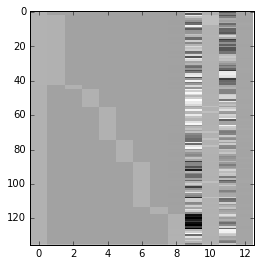

In [19]:
fig = plt.figure(figsize=(4,10))
ax = fig.add_subplot(111)
ax.imshow(glm_pheno, aspect=0.1, interpolation='None', cmap=plt.cm.Greys_r)

In [20]:
cov_weight = weight_store[..., cov_index.values]

In [21]:
res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)

# Look at the results

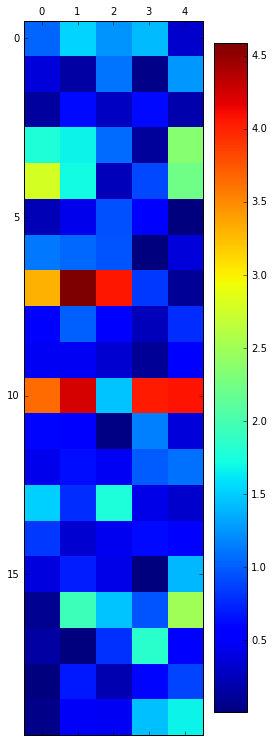

In [22]:
# Look at the uncorrected p-values for the GLM with diagnosis across networks
tmp = plt.matshow(-np.log10(pval_store))
tmp = plt.colorbar()

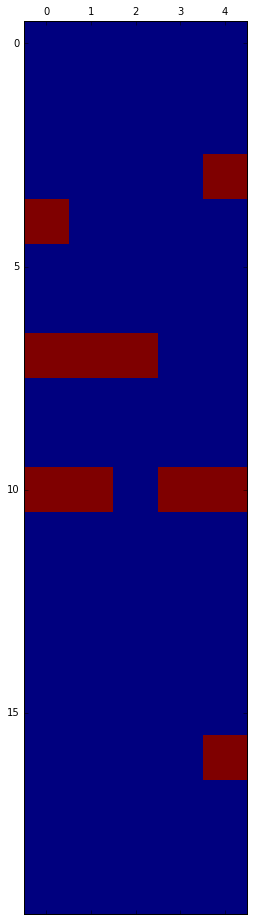

In [23]:
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
tmp = plt.matshow(pcorr_store)

In [24]:
gdavg_img = nib.Nifti1Image(gdavg, affine=m_img.get_affine(), header=m_img.get_header())

In [25]:
def show_simple(net_id, sbt_id, gdavg_img, sbt_store, view_mode='x', threshold=0.1, 
                view_range=[-70,-50, -30, -10, 10, 30, 50, 70]):

    sbt = sbt_store[net_id, sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    fig = plt.figure(figsize=(15,3))
    ax = fig.add_subplot(111)
    nlp.plot_stat_map(sbt_img, display_mode='x', threshold=threshold, 
                      cut_coords=view_range, black_bg=True,
                     axes=ax)
    return fig

In [26]:
view_range=[-70,-50, -30, -10, 10, 30, 50, 70]

## ADOS

### Network 3

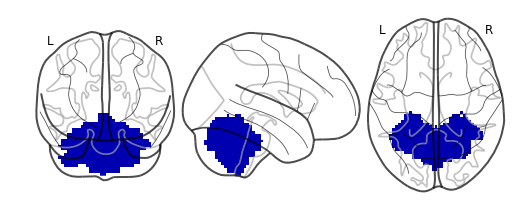

In [27]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 3), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [28]:
print(res_store[3][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     7.081
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           1.12e-09
Time:                        22:12:37   Log-Likelihood:                 32.148
No. Observations:                 136   AIC:                            -38.30
Df Residuals:                     123   BIC:                           -0.4309
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.2772      0.169     -1.641      

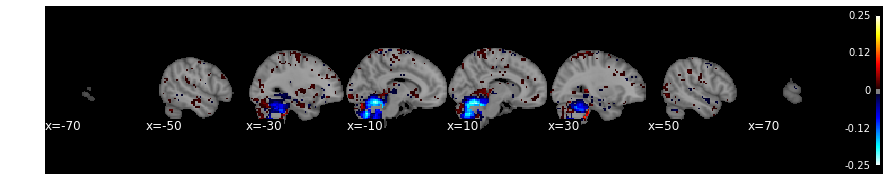

In [29]:
tmp = show_simple(3,4,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

### Network 4

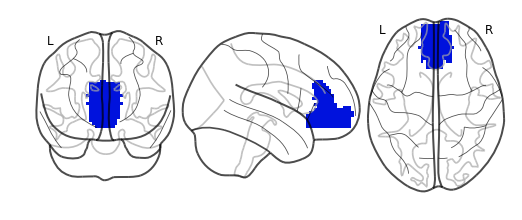

In [30]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 4), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [31]:
print(res_store[4][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     6.590
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           5.32e-09
Time:                        22:12:39   Log-Likelihood:                 51.535
No. Observations:                 136   AIC:                            -77.07
Df Residuals:                     123   BIC:                            -39.21
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.2365      0.146     -1.614      

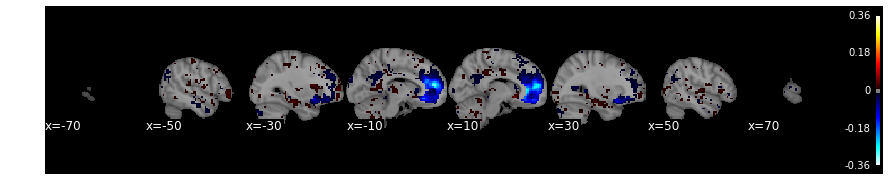

In [32]:
tmp = show_simple(4,0,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

### Network 7

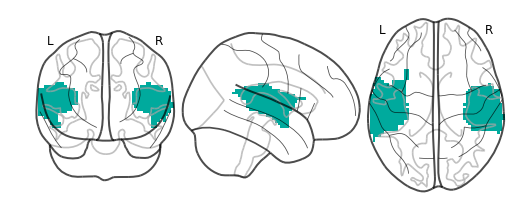

In [33]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 7), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [34]:
print(res_store[7][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     11.16
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           8.11e-15
Time:                        22:12:41   Log-Likelihood:                 66.031
No. Observations:                 136   AIC:                            -106.1
Df Residuals:                     123   BIC:                            -68.20
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.2797      0.132     -2.124      

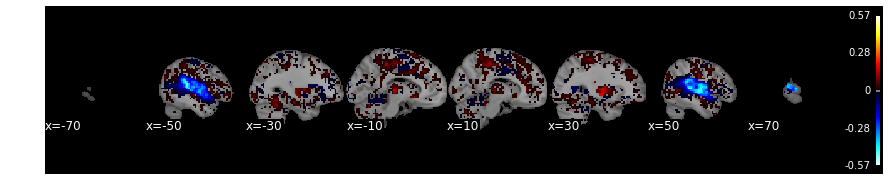

In [35]:
tmp = show_simple(7,0,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

In [36]:
print(res_store[7][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     10.05
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           1.68e-13
Time:                        22:12:41   Log-Likelihood:                 77.756
No. Observations:                 136   AIC:                            -129.5
Df Residuals:                     123   BIC:                            -91.65
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.0963      0.121     -0.797      

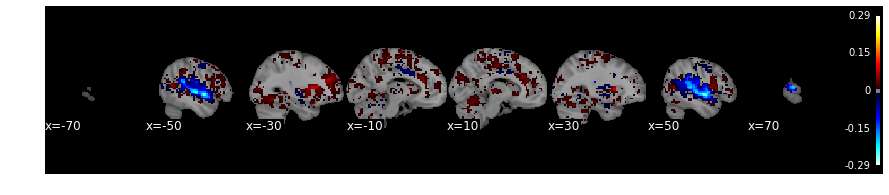

In [37]:
tmp = show_simple(7,1,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

In [38]:
print(res_store[7][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     9.570
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           6.51e-13
Time:                        22:12:42   Log-Likelihood:                 68.444
No. Observations:                 136   AIC:                            -110.9
Df Residuals:                     123   BIC:                            -73.02
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.1423      0.129      1.100      

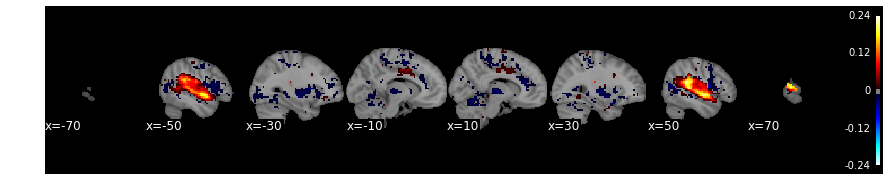

In [39]:
tmp = show_simple(7,2,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

## Network 10

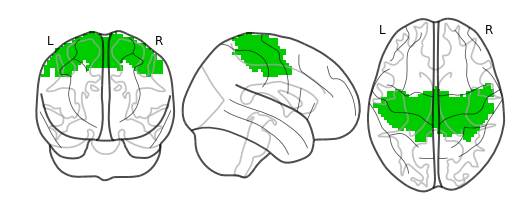

In [40]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 10), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [41]:
print(res_store[10][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     5.357
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           3.06e-07
Time:                        22:12:44   Log-Likelihood:                 37.782
No. Observations:                 136   AIC:                            -49.56
Df Residuals:                     123   BIC:                            -11.70
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.0637      0.162     -0.393      

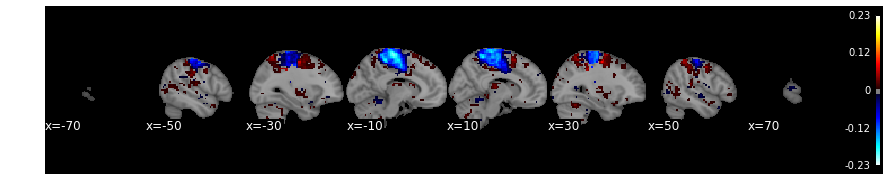

In [42]:
tmp = show_simple(10,0,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

In [43]:
print(res_store[10][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     7.086
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           1.10e-09
Time:                        22:12:45   Log-Likelihood:                 27.065
No. Observations:                 136   AIC:                            -28.13
Df Residuals:                     123   BIC:                             9.735
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.0723      0.175     -0.412      

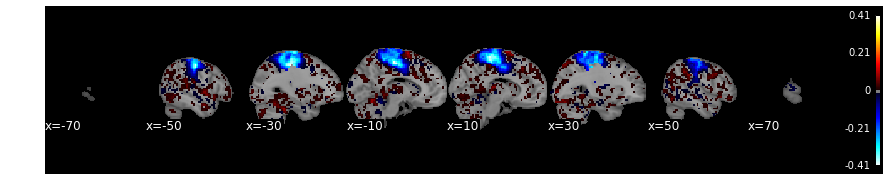

In [44]:
tmp = show_simple(10,1,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

In [45]:
print(res_store[10][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     6.735
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           3.35e-09
Time:                        22:12:46   Log-Likelihood:                 29.432
No. Observations:                 136   AIC:                            -32.86
Df Residuals:                     123   BIC:                             5.000
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.0964      0.172      0.559      

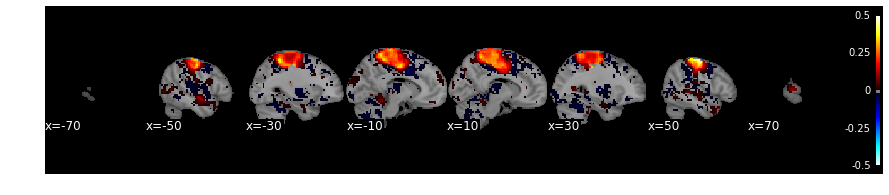

In [46]:
tmp = show_simple(10,3,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

In [47]:
print(res_store[10][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     6.638
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           4.57e-09
Time:                        22:12:47   Log-Likelihood:                 28.063
No. Observations:                 136   AIC:                            -30.13
Df Residuals:                     123   BIC:                             7.739
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.0638      0.174      0.366      

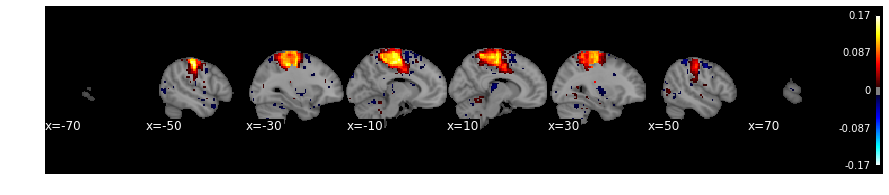

In [48]:
tmp = show_simple(10,4,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

## Network 16

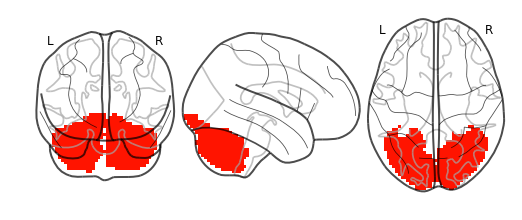

In [49]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 16), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [50]:
print(res_store[16][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     2.639
Date:                Mon, 09 Nov 2015   Prob (F-statistic):            0.00356
Time:                        22:12:49   Log-Likelihood:                 34.661
No. Observations:                 136   AIC:                            -43.32
Df Residuals:                     123   BIC:                            -5.458
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.1343      0.166     -0.810      

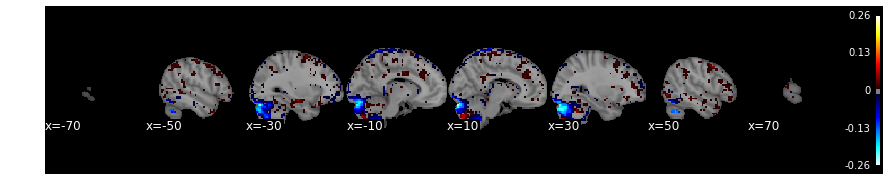

In [51]:
tmp = show_simple(16,4,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

# Look at Diagnosis

DX_GROUP has 308


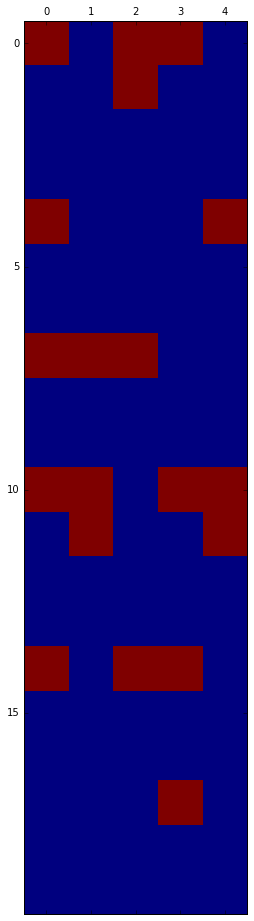

In [52]:
# Reduce the phenotype data to those subjects 
# that actually have the covariate of interest
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
cov = cov_list[-1]
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])

print('{} has {}'.format(cov, np.sum(cov_index)))

cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Demean the covariate
other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

cov_weight = weight_store[..., cov_index.values]

res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)
    
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
tmp = plt.matshow(pcorr_store)

## Network 0

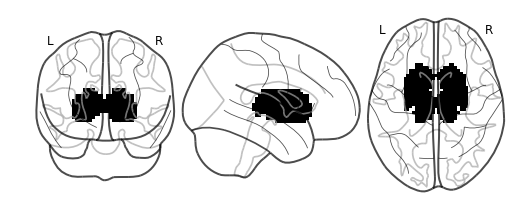

In [53]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 0), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [54]:
print(res_store[0][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     8.124
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           6.13e-14
Time:                        22:12:51   Log-Likelihood:                 82.532
No. Observations:                 308   AIC:                            -137.1
Df Residuals:                     294   BIC:                            -84.84
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.3003      0.075      4.026      

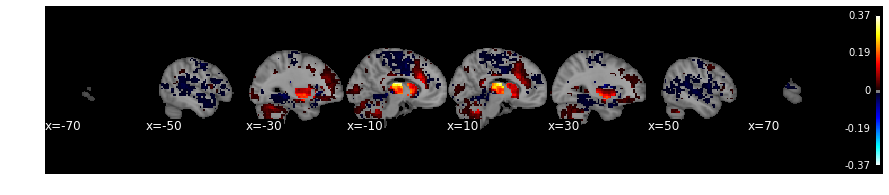

In [55]:
tmp = show_simple(0,0,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

In [56]:
print(res_store[0][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     13.13
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           8.32e-23
Time:                        22:12:52   Log-Likelihood:                 63.489
No. Observations:                 308   AIC:                            -98.98
Df Residuals:                     294   BIC:                            -46.76
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.3706      0.079     -4.671      

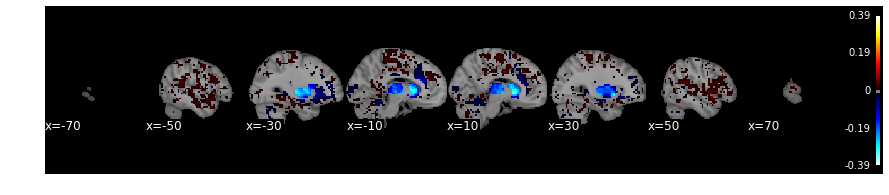

In [57]:
tmp = show_simple(0,2,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

In [58]:
print(res_store[0][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     14.88
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           1.12e-25
Time:                        22:12:52   Log-Likelihood:                 160.75
No. Observations:                 308   AIC:                            -293.5
Df Residuals:                     294   BIC:                            -241.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.2832      0.058     -4.894      

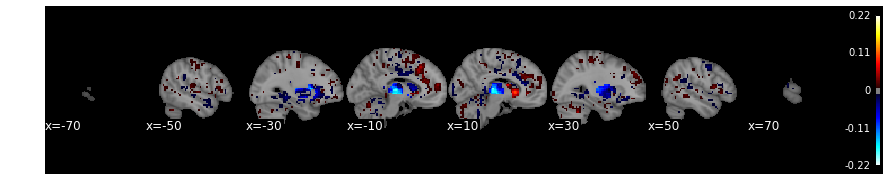

In [59]:
tmp = show_simple(0,3,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

## Network 4

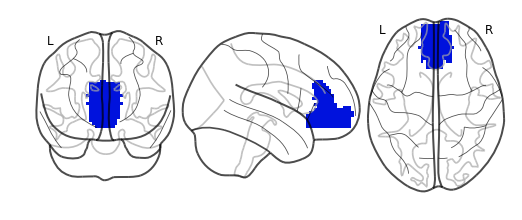

In [60]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 4), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### neg

In [61]:
print(res_store[4][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     6.932
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           1.08e-11
Time:                        22:12:54   Log-Likelihood:                 88.805
No. Observations:                 308   AIC:                            -149.6
Df Residuals:                     294   BIC:                            -97.39
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.4069      0.073     -5.567      

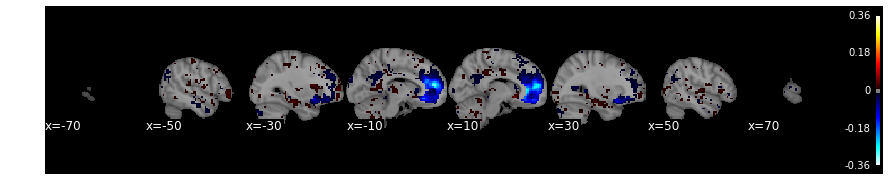

In [62]:
tmp = show_simple(4,0,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

In [63]:
print(res_store[4][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     7.213
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           3.17e-12
Time:                        22:12:55   Log-Likelihood:                 111.59
No. Observations:                 308   AIC:                            -195.2
Df Residuals:                     294   BIC:                            -143.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.1921      0.068      2.830      

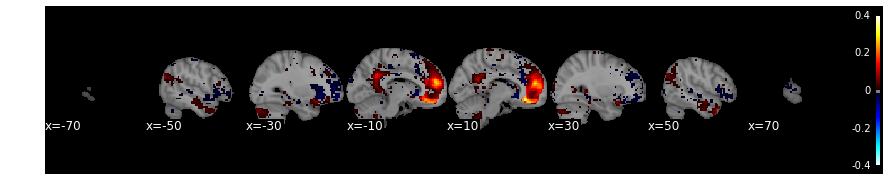

In [64]:
tmp = show_simple(4,4,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

## Network 7

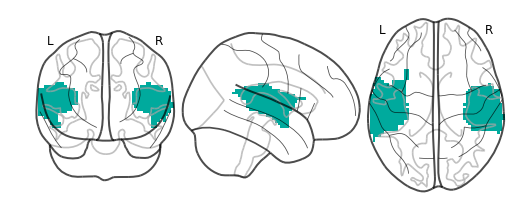

In [65]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 7), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [66]:
print(res_store[7][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     14.71
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           2.15e-25
Time:                        22:12:57   Log-Likelihood:                 136.46
No. Observations:                 308   AIC:                            -244.9
Df Residuals:                     294   BIC:                            -192.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.5379      0.063     -8.591      

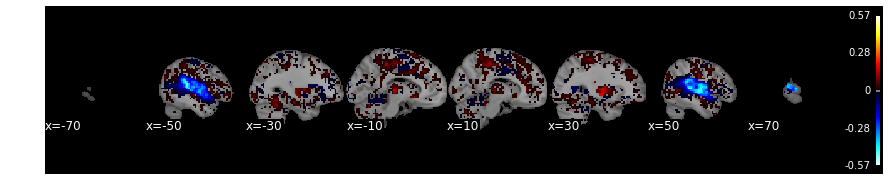

In [67]:
tmp = show_simple(7,0,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

In [68]:
print(res_store[7][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     13.45
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           2.45e-23
Time:                        22:12:58   Log-Likelihood:                 143.74
No. Observations:                 308   AIC:                            -259.5
Df Residuals:                     294   BIC:                            -207.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.4994      0.061     -8.167      

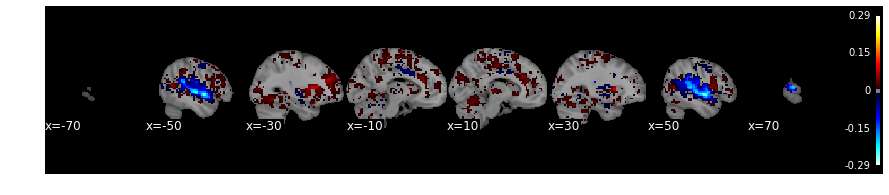

In [69]:
tmp = show_simple(7,1,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

In [70]:
print(res_store[7][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     13.42
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           2.74e-23
Time:                        22:12:59   Log-Likelihood:                 123.40
No. Observations:                 308   AIC:                            -218.8
Df Residuals:                     294   BIC:                            -166.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.5474      0.065      8.380      

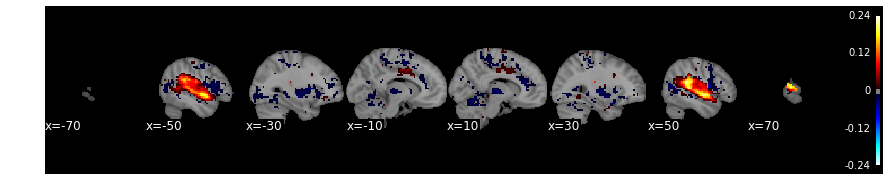

In [71]:
tmp = show_simple(7,2,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

## Network 10

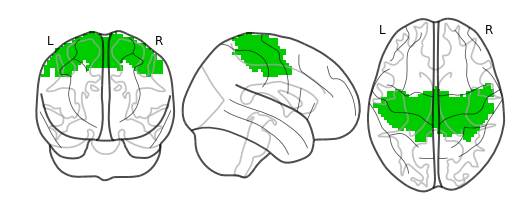

In [72]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 10), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [73]:
print(res_store[10][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     8.419
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           1.73e-14
Time:                        22:13:01   Log-Likelihood:                 50.416
No. Observations:                 308   AIC:                            -72.83
Df Residuals:                     294   BIC:                            -20.61
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.4633      0.083     -5.596      

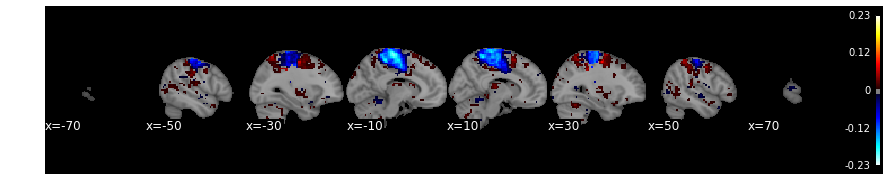

In [74]:
tmp = show_simple(10,0,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

In [75]:
print(res_store[10][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     10.06
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           1.72e-17
Time:                        22:13:01   Log-Likelihood:                 26.765
No. Observations:                 308   AIC:                            -25.53
Df Residuals:                     294   BIC:                             26.69
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.5537      0.089     -6.194      

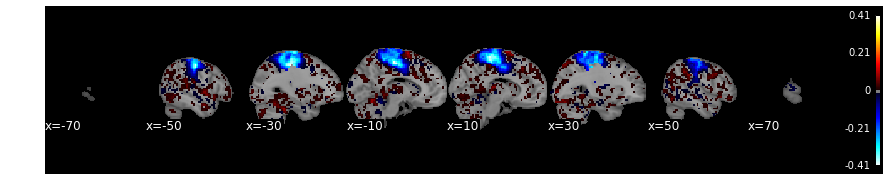

In [76]:
tmp = show_simple(10,1,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

In [77]:
print(res_store[10][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     9.461
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           2.11e-16
Time:                        22:13:03   Log-Likelihood:                 23.224
No. Observations:                 308   AIC:                            -18.45
Df Residuals:                     294   BIC:                             33.77
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.5381      0.090      5.950      

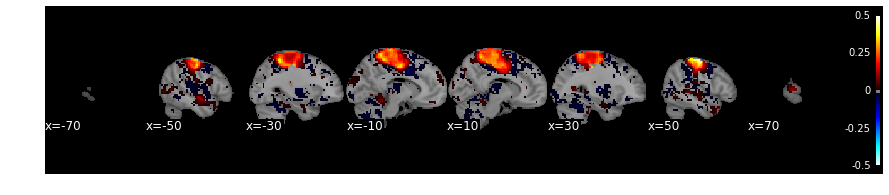

In [78]:
tmp = show_simple(10,3,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

In [79]:
print(res_store[10][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     9.583
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           1.27e-16
Time:                        22:13:03   Log-Likelihood:                 29.481
No. Observations:                 308   AIC:                            -30.96
Df Residuals:                     294   BIC:                             21.26
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.5485      0.089      6.190      

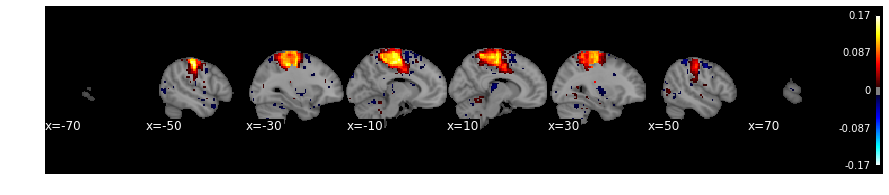

In [80]:
tmp = show_simple(10,4,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

## Network 14

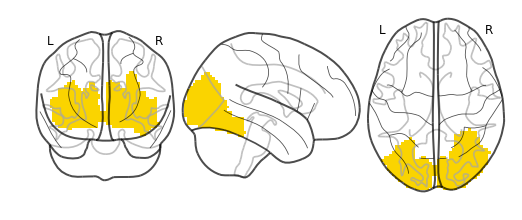

In [81]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 14), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [82]:
print(res_store[14][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     9.333
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           3.61e-16
Time:                        22:13:05   Log-Likelihood:                 67.140
No. Observations:                 308   AIC:                            -106.3
Df Residuals:                     294   BIC:                            -54.06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.3012      0.078     -3.841      

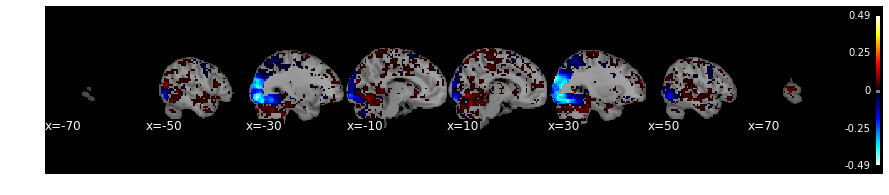

In [83]:
tmp = show_simple(14,0,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

In [84]:
print(res_store[14][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     10.73
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           1.13e-18
Time:                        22:13:06   Log-Likelihood:                 93.879
No. Observations:                 308   AIC:                            -159.8
Df Residuals:                     294   BIC:                            -107.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.1678      0.072      2.334      

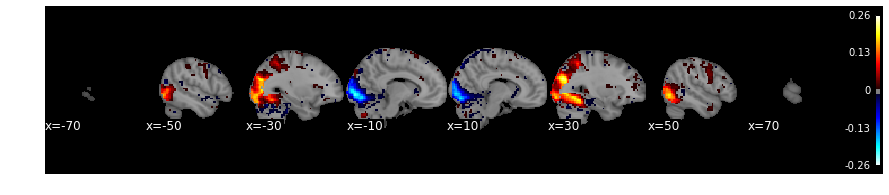

In [85]:
tmp = show_simple(14,2,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

In [86]:
print(res_store[14][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     15.83
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           3.47e-27
Time:                        22:13:07   Log-Likelihood:                 154.91
No. Observations:                 308   AIC:                            -281.8
Df Residuals:                     294   BIC:                            -229.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.0197      0.059     -0.334      

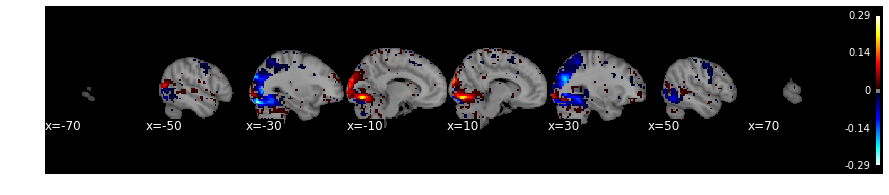

In [87]:
tmp = show_simple(14,3,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

## VIQ

VIQ has 276


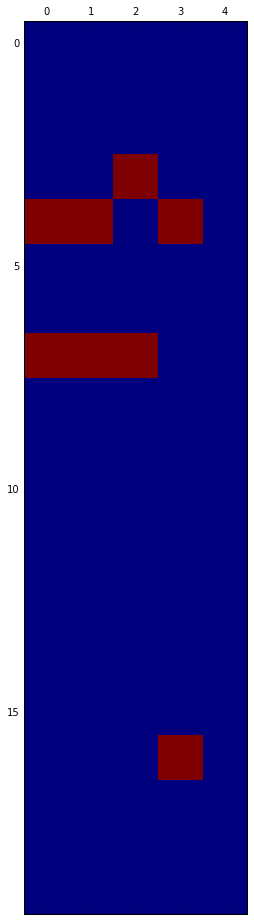

In [88]:
# Reduce the phenotype data to those subjects 
# that actually have the covariate of interest
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
cov = cov_list[1]
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])

print('{} has {}'.format(cov, np.sum(cov_index)))

cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Demean the covariate
other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

cov_weight = weight_store[..., cov_index.values]

res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)
    
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
tmp = plt.matshow(pcorr_store)

## Network 4

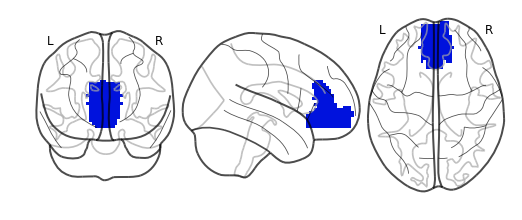

In [89]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 4), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [90]:
print(res_store[0][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     6.461
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           6.46e-09
Time:                        22:13:09   Log-Likelihood:                 68.911
No. Observations:                 276   AIC:                            -115.8
Df Residuals:                     265   BIC:                            -76.00
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.2995      0.078      3.837      

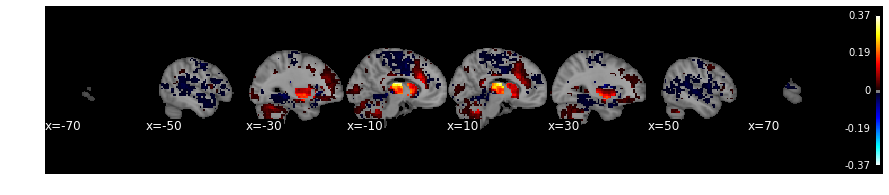

In [91]:
tmp = show_simple(0,0, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [92]:
print(res_store[0][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     28.89
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           4.00e-37
Time:                        22:13:10   Log-Likelihood:                 116.55
No. Observations:                 276   AIC:                            -211.1
Df Residuals:                     265   BIC:                            -171.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.3128      0.066      4.762      

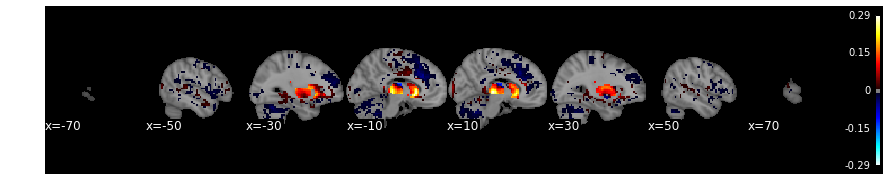

In [93]:
tmp = show_simple(0,1, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [94]:
print(res_store[0][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     18.96
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           3.88e-26
Time:                        22:13:11   Log-Likelihood:                 144.12
No. Observations:                 276   AIC:                            -266.2
Df Residuals:                     265   BIC:                            -226.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.2758      0.059     -4.639      

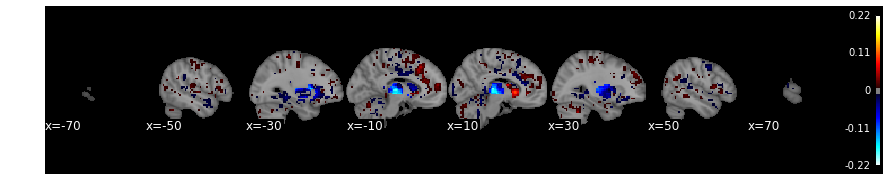

In [95]:
tmp = show_simple(0,3, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

## Network 7

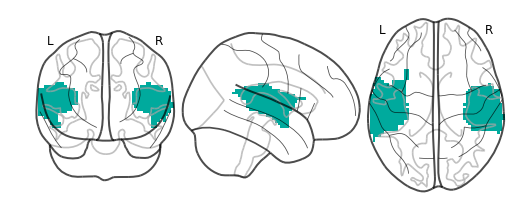

In [96]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 7), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [97]:
print(res_store[7][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     17.08
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           8.16e-24
Time:                        22:13:13   Log-Likelihood:                 125.58
No. Observations:                 276   AIC:                            -229.2
Df Residuals:                     265   BIC:                            -189.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.5605      0.064     -8.816      

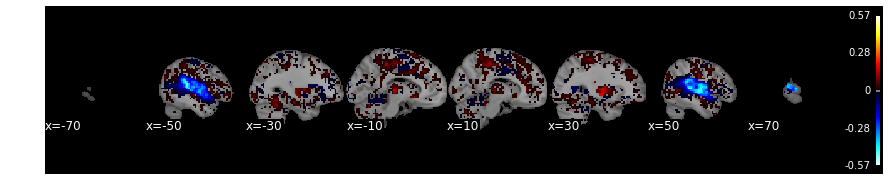

In [98]:
tmp = show_simple(7,0, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [99]:
print(res_store[7][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     15.62
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           5.99e-22
Time:                        22:13:14   Log-Likelihood:                 134.14
No. Observations:                 276   AIC:                            -246.3
Df Residuals:                     265   BIC:                            -206.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.5152      0.062     -8.359      

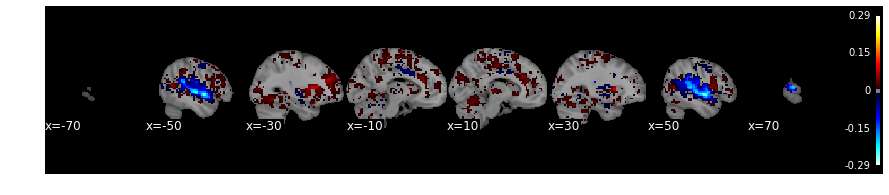

In [100]:
tmp = show_simple(7,1, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [101]:
print(res_store[7][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     15.54
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           7.47e-22
Time:                        22:13:14   Log-Likelihood:                 112.94
No. Observations:                 276   AIC:                            -203.9
Df Residuals:                     265   BIC:                            -164.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.5647      0.067      8.485      

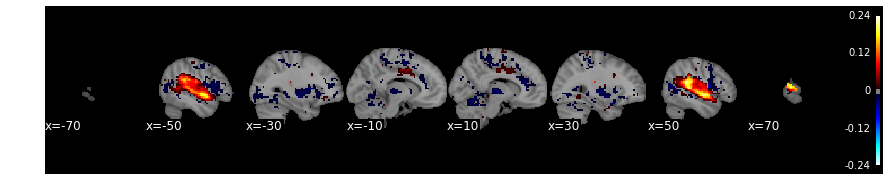

In [102]:
tmp = show_simple(7,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)